In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])
%matplotlib inline

## Load results

In [3]:
all_out = glob("out/**/*.pkl")

In [4]:
all_out = [load_pickle(p) for p in all_out]

In [5]:
all_out

[{'tabpfn_metrics': {'accuracy': 0.6687116564417178,
   'acc_macro': 0.6687116564417178,
   'racc': 0.6687116564417178,
   'kappa': 0.0,
   'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1]),
   'f1_macro': 0.4007352941176471,
   'f1_micro': 0.6687116564417178,
   'frac_valid': 1.0,
   'all_y_true': (#326) [1,1,1,1,1,0,0,0,0,0...],
   'all_y_pred': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [6]:
extracted_res = []
xgboost_results = []
tabpfn_results = []
dummy_results = []

for out in all_out:
    res = {
        "train_size": out["train_size"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
    }

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgb_metrics"]["accuracy"],
        "f1_macro": out["xgb_metrics"]["f1_macro"],
        "f1_micro": out["xgb_metrics"]["f1_micro"],
        "kappa": out["xgb_metrics"]["kappa"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn_metrics"]["accuracy"],
        "f1_macro": out["tabpfn_metrics"]["f1_macro"],
        "f1_micro": out["tabpfn_metrics"]["f1_micro"],
        "kappa": out["tabpfn_metrics"]["kappa"],
    }

    dummy_res = {
        "train_size": out["train_size"],
        "accuracy": out["dummy_metrics"]["accuracy"],
        "f1_macro": out["dummy_metrics"]["f1_macro"],
        "f1_micro": out["dummy_metrics"]["f1_micro"],
        "kappa": out["dummy_metrics"]["kappa"],
    }

    extracted_res.append(res)
    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)
    dummy_results.append(dummy_res)

In [7]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)
dummy_res = pd.DataFrame(dummy_results)

In [8]:
grouped_res = res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [9]:
grouped_xgboost_res = xgboost_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [10]:
grouped_dummy_res = dummy_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [11]:
grouped_tabpfn_res = tabpfn_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [12]:
grouped_res.loc[:]

frac_valid                  accuracy                            \
                 mean  std count  sem      mean       std count       sem   
train_size                                                                  
10                1.0  0.0     5  0.0  0.698292  0.018696     5  0.008361   
20                1.0  0.0     5  0.0  0.659985  0.072321     5  0.032343   
50                1.0  0.0     5  0.0  0.754567  0.103493     5  0.046283   

            f1_macro                            f1_micro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.454207  0.060941     5  0.027254  0.698292  0.018696     5   
20          0.448584  0.040597     5  0.018155  0.659985  0.072321     5   
50          0.510927  0.073876     5  0.033039  0.754567  0.103493     5   

                         kappa                            
                 sem      mean       std count       sem  
train_size                                                
10          0.008361  0.010410  0.069021     5  0.030867  
20          0.032343 -0.008135  0.061526     5  0.027515  
50          0.046283  0.082910  0.095018     5  0.042493

In [13]:
grouped_tabpfn_res

accuracy                            f1_macro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.663290  0.038227     5  0.017096  0.441509  0.108889     5   
20          0.603338  0.091581     5  0.040956  0.406996  0.028398     5   
50          0.734901  0.119219     5  0.053316  0.461506  0.091400     5   

                      f1_micro                               kappa            \
                 sem      mean       std count       sem      mean       std   
train_size                                                                     
10          0.048696  0.663290  0.038227     5  0.017096  0.061807  0.138205   
20          0.012700  0.603338  0.091581     5  0.040956 -0.026358  0.068711   
50          0.040875  0.734901  0.119219     5  0.053316  0.037953  0.124921   

                            
           count       sem  
train_size                  
10             5  0.061807  
20             5  0.030729  
50             5  0.055867

In [14]:
grouped_xgboost_res

accuracy                            f1_macro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.648706  0.076424     5  0.034178  0.488774  0.129968     5   
20          0.619832  0.074118     5  0.033147  0.455838  0.087042     5   
50          0.725058  0.116162     5  0.051949  0.471973  0.081794     5   

                      f1_micro                               kappa            \
                 sem      mean       std count       sem      mean       std   
train_size                                                                     
10          0.058123  0.648706  0.076424     5  0.034178  0.079567  0.208088   
20          0.038926  0.619832  0.074118     5  0.033147  0.020031  0.142465   
50          0.036579  0.725058  0.116162     5  0.051949  0.037177  0.103780   

                            
           count       sem  
train_size                  
10             5  0.093060  
20             5  0.063712  
50             5  0.046412

In [15]:
grouped_dummy_res

accuracy                            f1_macro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.647967  0.012775     5  0.005713  0.393163  0.004713     5   
20          0.567100  0.182424     5  0.081583  0.353599  0.088933     5   
50          0.745066  0.132990     5  0.059475  0.424347  0.042840     5   

                      f1_micro                           kappa                  
                 sem      mean       std count       sem  mean  std count  sem  
train_size                                                                      
10          0.002108  0.647967  0.012775     5  0.005713   0.0  0.0     5  0.0  
20          0.039772  0.567100  0.182424     5  0.081583   0.0  0.0     5  0.0  
50          0.019158  0.745066  0.132990     5  0.059475   0.0  0.0     5  0.0

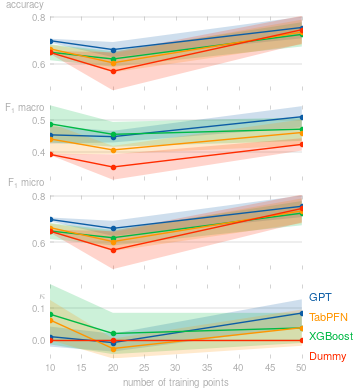

In [16]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(
        4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
    )

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[ :].index,
            grouped_res.loc[:][metric]["mean"],
            marker="o",
            label="GPT",
        )
        ax[i].fill_between(
            grouped_res.loc[ :].index,
            grouped_res.loc[:][metric]["mean"] - grouped_res.loc[ :][metric]["sem"],
            grouped_res.loc[ :][metric]["mean"] + grouped_res.loc[ :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[ :].index,
            grouped_xgboost_res.loc[ :][metric]["mean"],
            marker="o",
            label="XGBoost",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[ :].index,
            grouped_xgboost_res.loc[:][metric]["mean"]
            - grouped_xgboost_res.loc[ :][metric]["sem"],
            grouped_xgboost_res.loc[:][metric]["mean"]
            + grouped_xgboost_res.loc[:][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[ :].index,
            grouped_tabpfn_res.loc[ :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[ :].index,
            grouped_tabpfn_res.loc[:][metric]["mean"]
            - grouped_tabpfn_res.loc[ :][metric]["sem"],
            grouped_tabpfn_res.loc[ :][metric]["mean"]
            + grouped_tabpfn_res.loc[:][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_dummy_res.loc[ :].index,
            grouped_dummy_res.loc[ :][metric]["mean"],
            marker="o",
            label="Dummy",
        )
        ax[i].fill_between(
            grouped_dummy_res.loc[ :].index,
            grouped_dummy_res.loc[:][metric]["mean"]
            - grouped_dummy_res.loc[ :][metric]["sem"],
            grouped_dummy_res.loc[ :][metric]["mean"]
            + grouped_dummy_res.loc[:][metric]["sem"],
            alpha=0.2,
        )

    matplotx.line_labels(ax[-1], fontsize=8)
    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])
    ax[-1].set_xlabel("number of training points", labelpad=4)

    fig.savefig("mof_synthesizability-classification_results_2.pdf", bbox_inches="tight")

In [17]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

KeyError: 2

In [ ]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

KeyError: 2